In [1]:
from sklearn.model_selection import train_test_split

import pandas as pd
import xgboost as xgb

In [2]:
df = pd.read_pickle('../../data/Backtesting/r2k_qfl_data_20y_m.pkl')
df= df.reset_index()
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index(['DATE',"UNIVERSE"])

In [3]:
df = df[df['12m_fwd_ret'].isna()==False]

In [4]:
x1 =df[['market_val','fcfy','bp','dy','peg','ey','ocfy','debt_to_assets','curr_ration','cfroic','res_ret_mom']]

In [5]:
y = df['12m_fwd_ret']

In [6]:
# Convert 'date' to datetime if it's not

# Define a function to fill NA with median
def fill_na_with_median(data):
    return data.fillna(data.median())

# Apply it across the data
X = x1.groupby('DATE').transform(fill_na_with_median)

In [7]:
import numpy as np
rng = np.random.RandomState(1994)
# Generate a synthetic dataset for demo, the generate process is from the sklearn
# example.
# Train on 0.05 and 0.95 quantiles. The model is similar to multi-class and
# multi-target models.
alpha = np.array([0.05, 0.5, 0.95])
evals_result= {}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)
# We will be using the `hist` tree method, quantile DMatrix can be used to preserve
# memory.
# Do not use the `exact` tree method for quantile regression, otherwise the
# performance might drop.
Xy = xgb.QuantileDMatrix(X, y)
# use Xy as a reference
Xy_test = xgb.QuantileDMatrix(X_test, y_test, ref=Xy)

booster = xgb.train(
    {
        # Use the quantile objective function.
        "objective": "reg:quantileerror",
        "tree_method": "hist",
        "quantile_alpha": alpha,
        # Let's try not to overfit.
        "learning_rate": 0.04,
        "max_depth": 5,
    },
    Xy,
    num_boost_round=100,
    early_stopping_rounds=2,
    # The evaluation result is a weighted average across multiple quantiles.
    evals=[(Xy, "Train"), (Xy_test, "Test")],
    evals_result=evals_result,
)

[0]	Train-quantile:11.01790	Test-quantile:11.56339
[1]	Train-quantile:10.42839	Test-quantile:10.98306
[2]	Train-quantile:9.93303	Test-quantile:10.48292
[3]	Train-quantile:9.52459	Test-quantile:10.06397
[4]	Train-quantile:9.17583	Test-quantile:9.70880
[5]	Train-quantile:8.86999	Test-quantile:9.39322
[6]	Train-quantile:8.59171	Test-quantile:9.11345
[7]	Train-quantile:8.34803	Test-quantile:8.86643
[8]	Train-quantile:8.14427	Test-quantile:8.65051
[9]	Train-quantile:7.95703	Test-quantile:8.45843
[10]	Train-quantile:7.79728	Test-quantile:8.28703
[11]	Train-quantile:7.64905	Test-quantile:8.13290
[12]	Train-quantile:7.51760	Test-quantile:7.99456
[13]	Train-quantile:7.39793	Test-quantile:7.86650
[14]	Train-quantile:7.29577	Test-quantile:7.75640
[15]	Train-quantile:7.20033	Test-quantile:7.65670
[16]	Train-quantile:7.11904	Test-quantile:7.56553
[17]	Train-quantile:7.04344	Test-quantile:7.48252
[18]	Train-quantile:6.97448	Test-quantile:7.40662
[19]	Train-quantile:6.91555	Test-quantile:7.33833
[20]

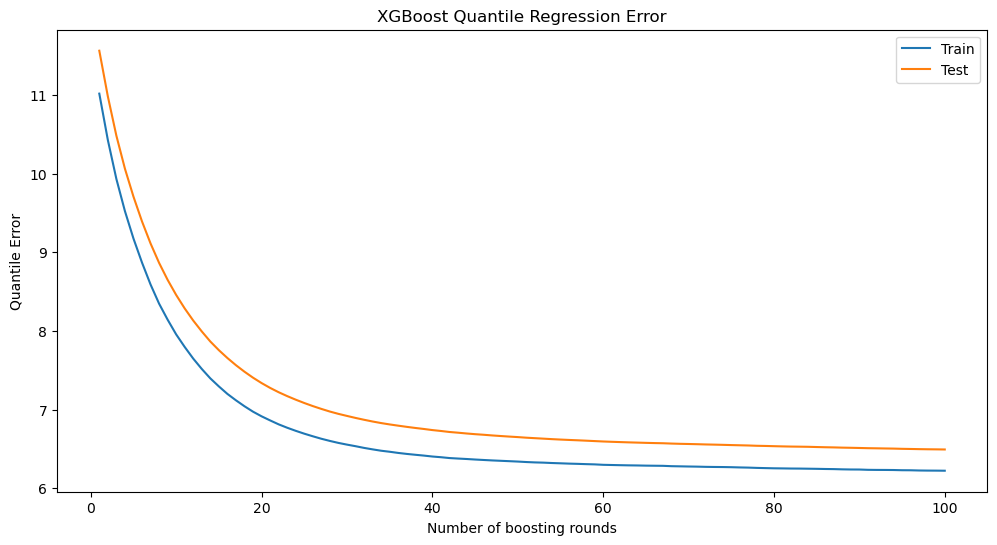

In [8]:
import matplotlib.pyplot as plt

# Get metric values from evals_result
train_metric = evals_result['Train']['quantile']
test_metric = evals_result['Test']['quantile']

# Create a range (x-axis) for number of boosting rounds
x_values = range(1, len(train_metric) + 1)

# Start figure
fig, ax = plt.subplots(figsize=(12,6))

# Plot values
ax.plot(x_values, train_metric, label='Train')
ax.plot(x_values, test_metric, label='Test')

# Add title and labels
ax.set_title('XGBoost Quantile Regression Error')
ax.set_xlabel('Number of boosting rounds')
ax.set_ylabel('Quantile Error')

# Add legend
ax.legend()

# Display plot
plt.show()

In [9]:
# Predict using the trained model
preds = booster.predict(Xy)
preds

array([[-25.342455  ,   2.1061418 ,  46.45676   ],
       [-23.064493  ,   5.051202  ,  38.65017   ],
       [-28.455513  ,   3.2707453 ,  43.83377   ],
       ...,
       [-49.04174   ,  -0.3956361 ,  97.0243    ],
       [-37.08474   ,  -0.24474001,  74.91911   ],
       [-35.267605  ,   3.5549335 ,  70.40138   ]], dtype=float32)

In [10]:
X['quantile_0.05'] = preds[:, 0]
X['quantile_0.50'] = preds[:, 1]
X['quantile_0.95'] = preds[:, 2]
X

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 CORSQ      672.505000   3.699401  0.525311  1.202400   1.483637   
           MCS        335.384151 -11.905992  0.858255  1.585586  10.502121   
           HAR       1278.264023   5.672346  0.307900  0.273973   2.277045   
           BANF       335.239983   5.910332  0.541935  1.662992   0.816189   
           LANC      1041.489053   8.756591  0.386595  2.316258   1.099718   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.744813   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.744813   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.744813   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.744813   
           HARP       493.647652   9.565017  0.144086  0.000000   1.744813   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 CORSQ      7.763919   3.908794        0.036491     1.629756   
           MCS        5.057919  13.979033        0.423888     0.402932   
           HAR        5.479234  12.253198        0.243800     1.856838   
           BANF       7.613773   9.033106        0.036287     5.371699   
           LANC       8.918365  10.893912        0.022234     3.274372   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 CORSQ      7.219852   127.494225     -25.342455       2.106142   
           MCS        9.027527    18.455162     -23.064493       5.051202   
           HAR       21.761690    38.165245     -28.455513       3.270745   
           BANF      13.556413    32.523865     -25.231308       3.369446   
           LANC      28.212130    -6.679672     -24.386473       4.487684   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -26.323250       3.414549   
           SEAC     -23.111887   -68.807110     -59.927650      -0.101876   
           CBUS     -53.205605   -53.127075     -49.041740      -0.395636   
           NBSE     -61.534245     1.977014     -37.084740      -0.244740   
           HARP      42.655357    -2.426529     -35.267605       3.554934   

                     quantile_0.95  
DATE       UNIVERSE                 
2000-12-29 CORSQ         46.456760  
           MCS           38.650169  
           HAR           43.833771  
           BANF          49.465263  
           LANC          44.562424  
...                            ...  
2020-12-31 ADEA          41.227489  
           SEAC         138.354233  
           CBUS          97.024300  
           NBSE          74.919113  
           HARP          70.401382  

[463330 rows x 14 columns]

In [11]:
df_f= X.join(y)
df_f

market_val       fcfy        bp        dy        peg  \
DATE       UNIVERSE                                                          
2000-12-29 CORSQ      672.505000   3.699401  0.525311  1.202400   1.483637   
           MCS        335.384151 -11.905992  0.858255  1.585586  10.502121   
           HAR       1278.264023   5.672346  0.307900  0.273973   2.277045   
           BANF       335.239983   5.910332  0.541935  1.662992   0.816189   
           LANC      1041.489053   8.756591  0.386595  2.316258   1.099718   
...                          ...        ...       ...       ...        ...   
2020-12-31 ADEA      2149.036191   8.629018  0.584158  0.956938   1.744813   
           SEAC        50.700690 -21.748438  0.667783  0.000000   1.744813   
           CBUS       157.526437 -25.469511  0.223100  0.000000   1.744813   
           NBSE       162.243133  -7.053142  0.193163  0.000000   1.744813   
           HARP       493.647652   9.565017  0.144086  0.000000   1.744813   

                            ey       ocfy  debt_to_assets  curr_ration  \
DATE       UNIVERSE                                                      
2000-12-29 CORSQ      7.763919   3.908794        0.036491     1.629756   
           MCS        5.057919  13.979033        0.423888     0.402932   
           HAR        5.479234  12.253198        0.243800     1.856838   
           BANF       7.613773   9.033106        0.036287     5.371699   
           LANC       8.918365  10.893912        0.022234     3.274372   
...                        ...        ...             ...          ...   
2020-12-31 ADEA      -2.219763   8.802467        0.408832     2.477170   
           SEAC     -33.161850 -21.101784        0.150393     2.297560   
           CBUS     -27.878492 -24.461292        0.318528     4.832302   
           NBSE     -10.730432  -6.610691        0.004023    10.416623   
           HARP     -12.529428   9.800803        0.076658     3.488389   

                        cfroic  res_ret_mom  quantile_0.05  quantile_0.50  \
DATE       UNIVERSE                                                         
2000-12-29 CORSQ      7.219852   127.494225     -25.342455       2.106142   
           MCS        9.027527    18.455162     -23.064493       5.051202   
           HAR       21.761690    38.165245     -28.455513       3.270745   
           BANF      13.556413    32.523865     -25.231308       3.369446   
           LANC      28.212130    -6.679672     -24.386473       4.487684   
...                        ...          ...            ...            ...   
2020-12-31 ADEA      12.993757     2.121711     -26.323250       3.414549   
           SEAC     -23.111887   -68.807110     -59.927650      -0.101876   
           CBUS     -53.205605   -53.127075     -49.041740      -0.395636   
           NBSE     -61.534245     1.977014     -37.084740      -0.244740   
           HARP      42.655357    -2.426529     -35.267605       3.554934   

                     quantile_0.95  12m_fwd_ret  
DATE       UNIVERSE                              
2000-12-29 CORSQ         46.456760          0.0  
           MCS           38.650169          0.0  
           HAR           43.833771          0.0  
           BANF          49.465263          0.0  
           LANC          44.562424          0.0  
...                            ...          ...  
2020-12-31 ADEA          41.227489          0.0  
           SEAC         138.354233          0.0  
           CBUS          97.024300          0.0  
           NBSE          74.919113          0.0  
           HARP          70.401382          0.0  

[463330 rows x 15 columns]

<Axes: xlabel='quantile_0.95', ylabel='12m_fwd_ret'>

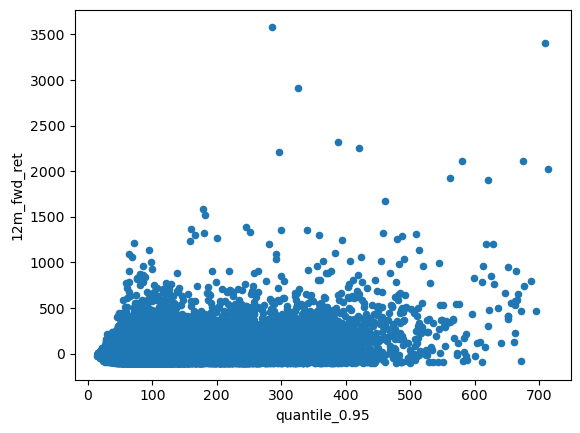

In [12]:
df_f.plot(x = 'quantile_0.95',y='12m_fwd_ret',kind='scatter')

<Axes: xlabel='quantile_0.05', ylabel='12m_fwd_ret'>

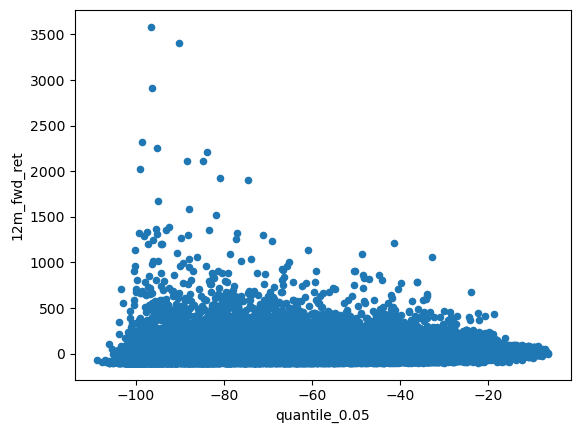

In [13]:
df_f.plot(x = 'quantile_0.05',y='12m_fwd_ret',kind='scatter')

<Axes: xlabel='quantile_0.50', ylabel='12m_fwd_ret'>

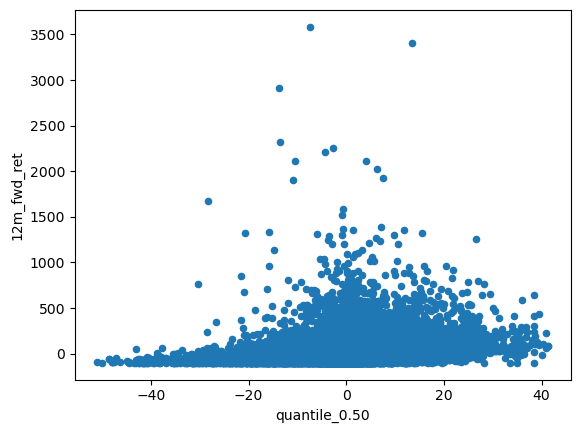

In [14]:
df_f.plot(x = 'quantile_0.50',y='12m_fwd_ret',kind='scatter')

In [93]:
N = 250  # The number of stocks to hold in the portfolio

# Define a function to select top/bottom N stocks for each date
# Select top/bottom N stocks for each date
def select_stocks(df):
    df = df.sort_values('quantile_0.50', ascending=False)
    top_stocks = df.head(N).copy()  # Take a copy to keep the original data unchanged
    top_stocks['strategy'] = 'long'  # Add 'strategy' column
    bottom_stocks = df.tail(N).copy()   # Take a copy to keep the original data unchanged
    bottom_stocks['strategy'] = 'short'  # Add 'strategy' column
    return pd.concat([top_stocks, bottom_stocks])

# Apply the function to each group (date)
portfolios = df_f.groupby(df_f.index.get_level_values('DATE')).apply(select_stocks)

In [94]:
portfolios.index = portfolios.unstack(0).index

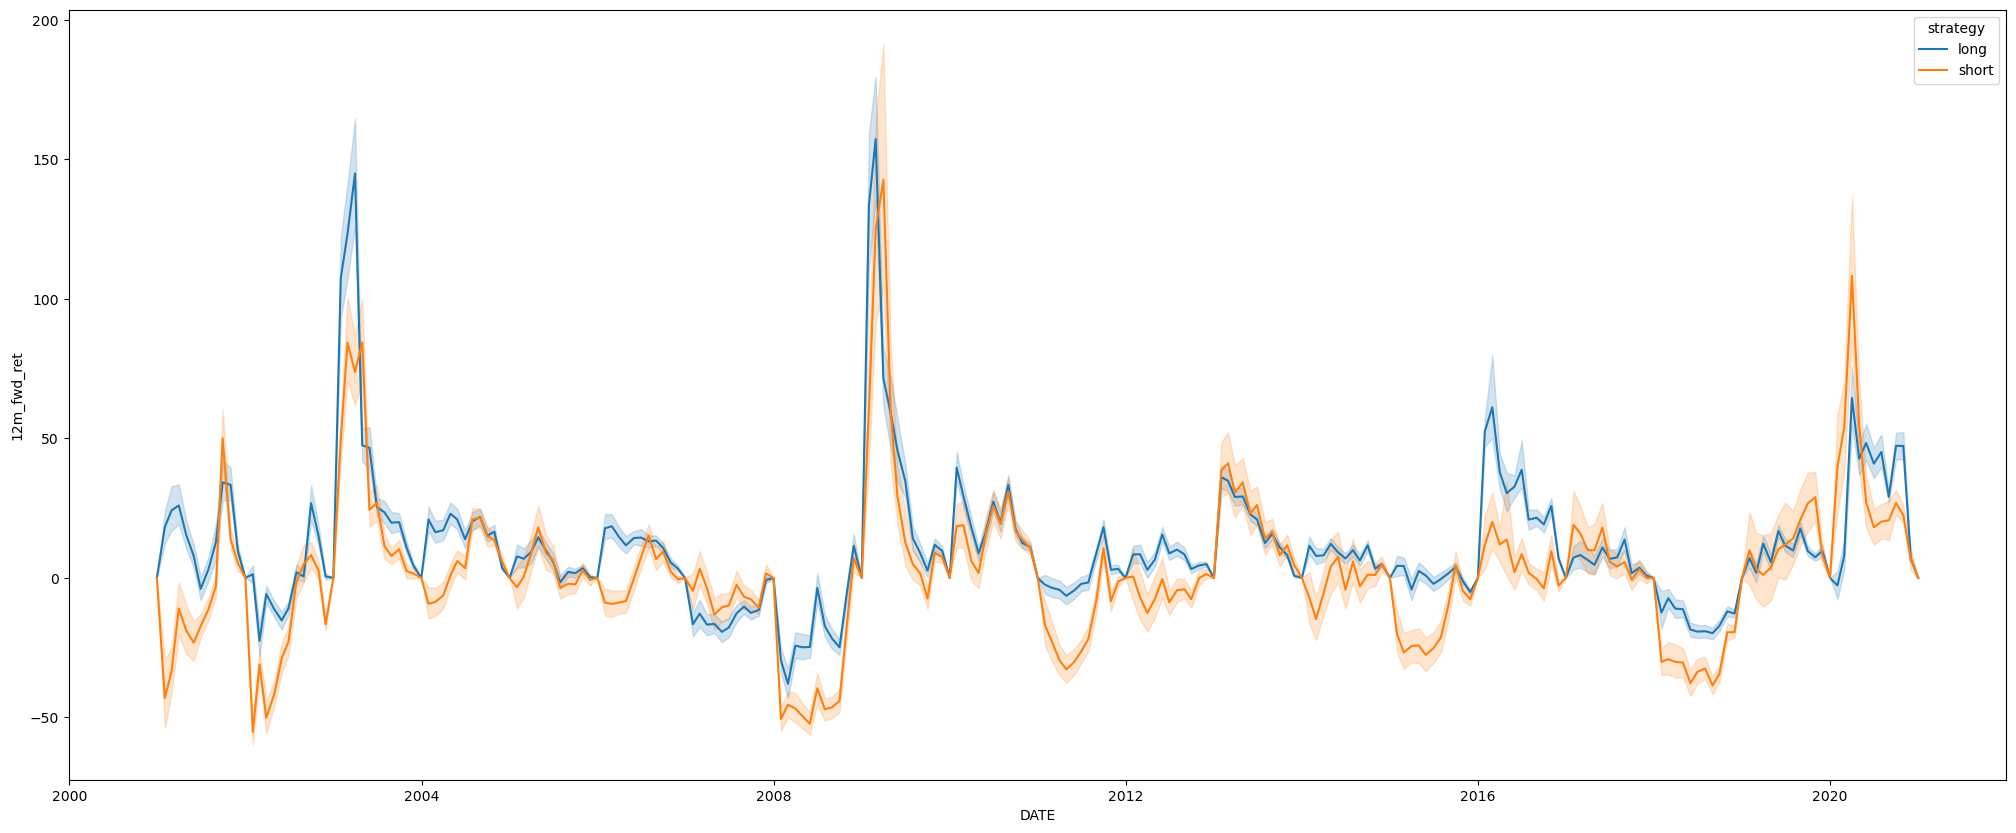

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize = (25,10))
sns.lineplot(data = portfolios.reset_index(),x = 'DATE',y='12m_fwd_ret',hue='strategy')
plt.show()

In [104]:
# Define the number N of top/bottom securities to select
N = 50

# For each date, calculate the spread and select the top/bottom N securities
def select_securities(df):
    df['spread'] = df['quantile_0.95'] - df['quantile_0.05']
    top_securities = df.nsmallest(N, 'spread')  # 10 securities with smallest spread
    top_securities['strategy']= 'long'
    bottom_securities = df.nlargest(N, 'spread')  # 10 securities with largest spread
    bottom_securities['strategy']='short'
    return pd.concat([top_securities, bottom_securities])  # combine top and bottom into a single DataFrame

# Group by date and apply the selection operation to each group
portfolio_df = df_f.groupby(level='DATE').apply(select_securities)

# portfolio_df now contains the top/bottom N securities for each date

<Axes: xlabel='DATE'>

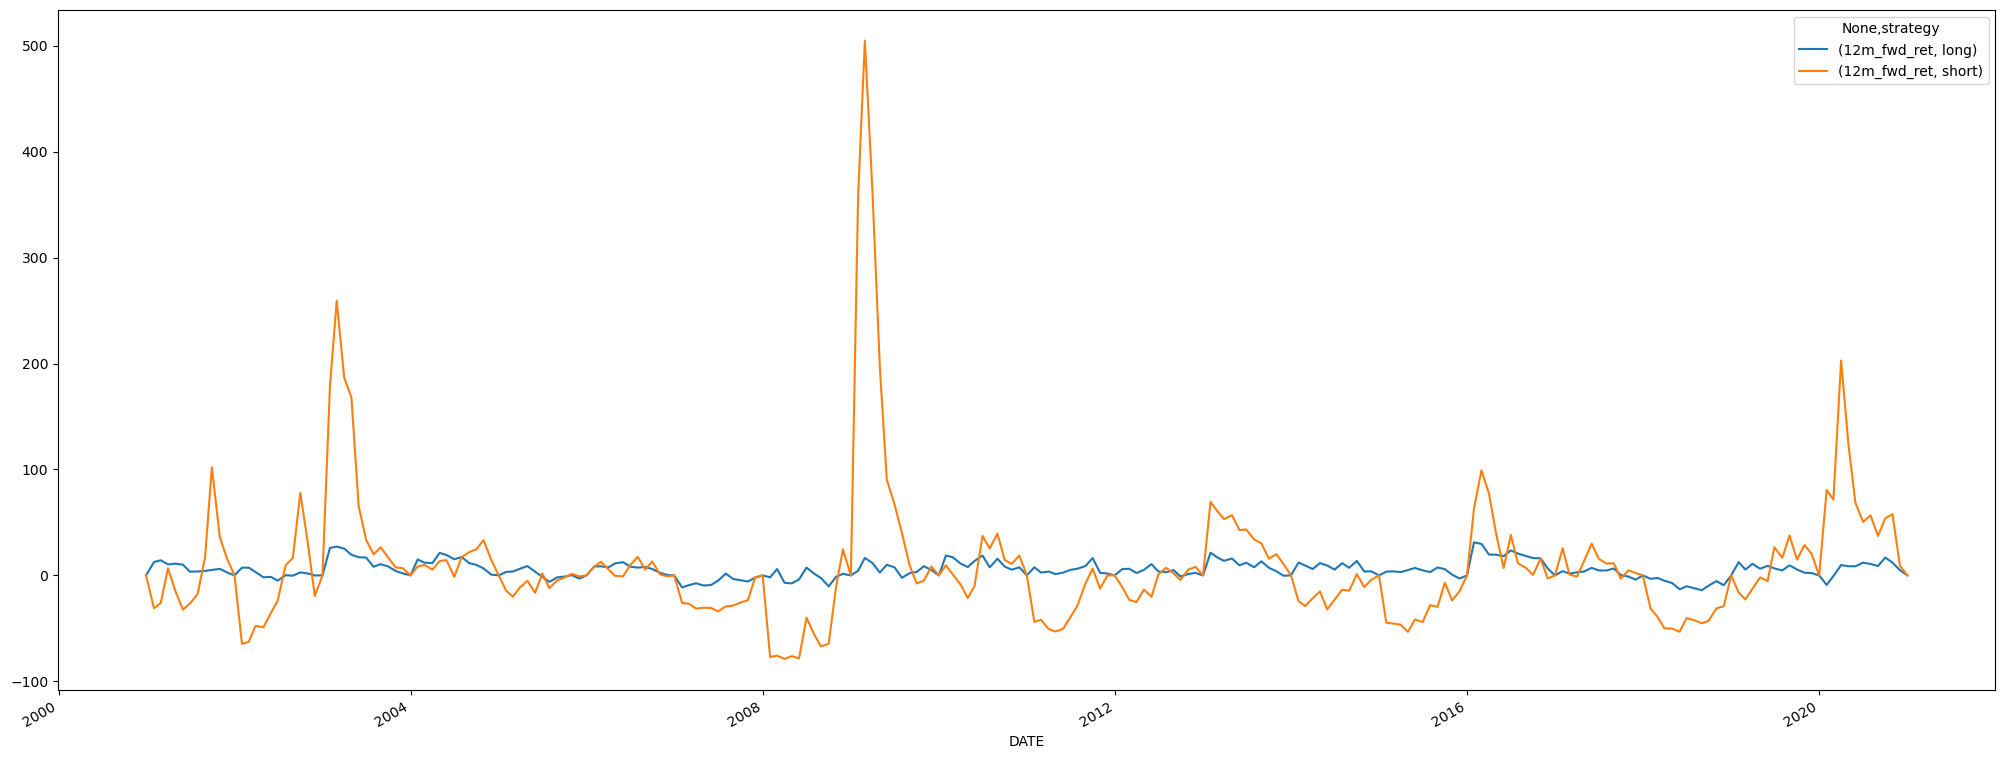

In [108]:

portfolio_df.groupby(['DATE','strategy']).agg({'12m_fwd_ret':'mean'}).unstack().plot(figsize = (25,10))

In [98]:
portfolios.groupby(["DATE","strategy"]).agg({'12m_fwd_ret':'mean'})

12m_fwd_ret
DATE       strategy             
2000-12-29 long         0.000000
           short        0.000000
2001-01-31 long        18.145543
           short      -43.047122
2001-02-28 long        24.192832
...                          ...
2020-10-30 short       22.538914
2020-11-30 long         6.892584
           short        6.763566
2020-12-31 long         0.000000
           short        0.000000

[482 rows x 1 columns]

In [99]:
dfx = df.join(portfolios['strategy'],how='left')

In [100]:
dfx['strategy']= dfx['strategy'].fillna('No Strategy')

<Axes: xlabel='DATE'>

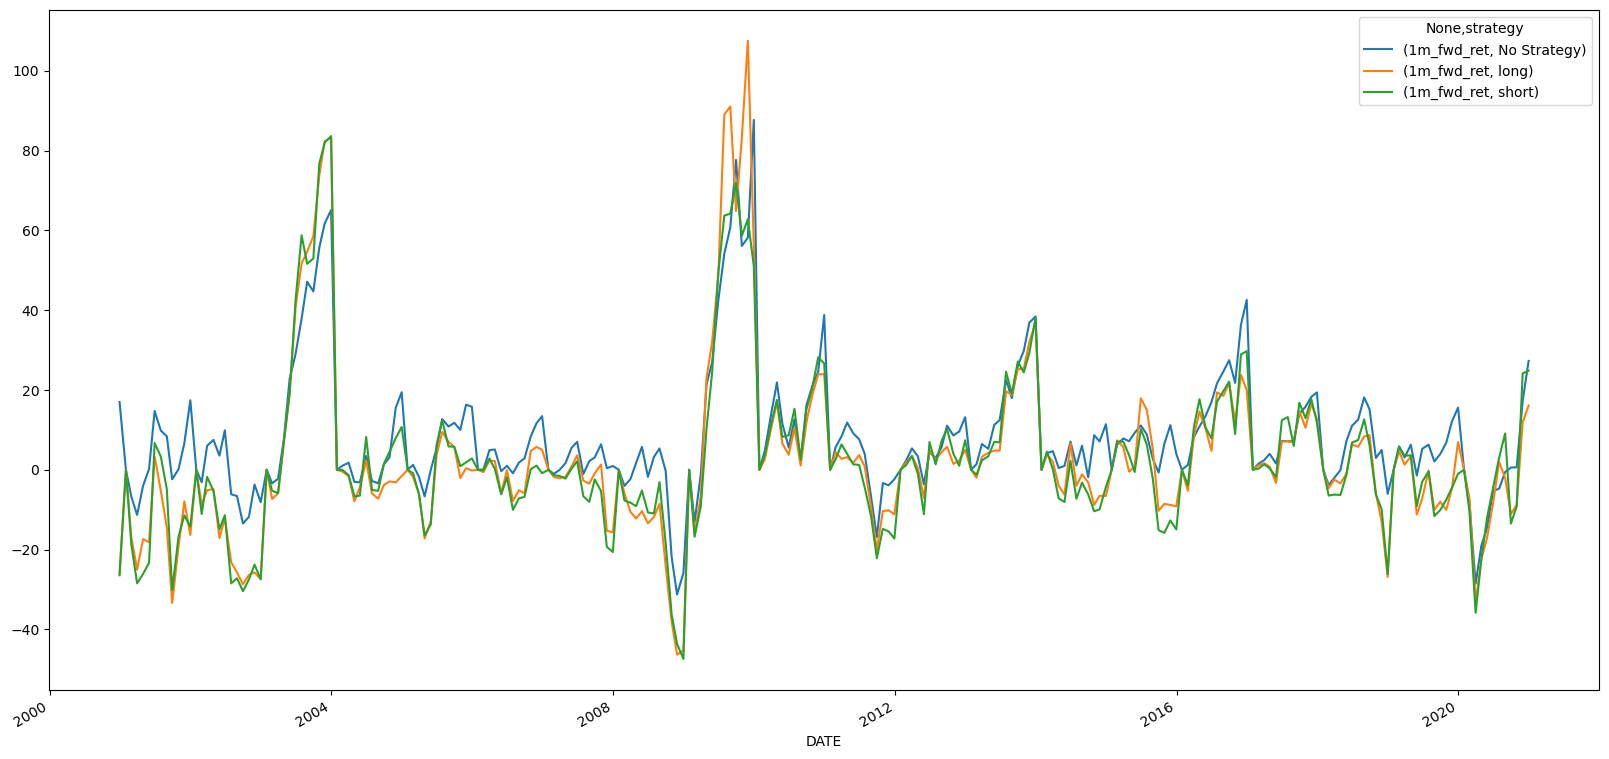

In [101]:
dfx.groupby(['DATE','strategy']).agg({'1m_fwd_ret':'mean'}).unstack().plot(figsize=(20,10))